In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif

### Load dataset

In [2]:
from ucimlrepo import fetch_ucirepo 

parkinsons = fetch_ucirepo(id=174) 
X = parkinsons.data.features 
y = parkinsons.data.targets
 
print(parkinsons.metadata) 
print(parkinsons.variables) 

{'uci_id': 174, 'name': 'Parkinsons', 'repository_url': 'https://archive.ics.uci.edu/dataset/174/parkinsons', 'data_url': 'https://archive.ics.uci.edu/static/public/174/data.csv', 'abstract': "Oxford Parkinson's Disease Detection Dataset", 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 197, 'num_features': 22, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['status'], 'index_col': ['name'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2007, 'last_updated': 'Wed Feb 14 2024', 'dataset_doi': '10.24432/C59C74', 'creators': ['Max Little'], 'intro_paper': {'ID': 385, 'type': 'NATIVE', 'title': 'Exploiting Nonlinear Recurrence and Fractal Scaling Properties for Voice Disorder Detection', 'authors': 'Max A. Little, P. McSharry, S. Roberts, D. Costello, I. Moroz', 'venue': 'BioMedical Engineering OnLine', 'year': 2007, 'journal': None, 'DOI': '10.1186/1475-925X-6-23', 'URL

In [3]:
path = "https://archive.ics.uci.edu/static/public/174/data.csv"
df = pd.read_csv(path)
df.head(200)

,name,MDVP:Fo,MDVP:Fhi,MDVP:Flo,MDVP:Jitter,MDVP:Jitter.1,MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,...,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,...,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,...,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,phon_R01_S01_4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,...,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,phon_R01_S01_5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,...,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190,phon_R01_S50_2,174.188,230.978,94.261,0.00459,0.00003,0.00263,0.00259,0.00790,0.04087,...,0.07008,0.02764,19.517,0,0.448439,0.657899,-6.538586,0.121952,2.657476,0.133050
191,phon_R01_S50_3,209.516,253.017,89.488,0.00564,0.00003,0.00331,0.00292,0.00994,0.02751,...,0.04812,0.01810,19.147,0,0.431674,0.683244,-6.195325,0.129303,2.784312,0.168895
192,phon_R01_S50_4,174.688,240.005,74.287,0.01360,0.00008,0.00624,0.00564,0.01873,0.02308,...,0.03804,0.10715,17.883,0,0.407567,0.655683,-6.787197,0.158453,2.679772,0.131728
193,phon_R01_S50_5,198.764,396.961,74.904,0.00740,0.00004,0.00370,0.00390,0.01109,0.02296,...,0.03794,0.07223,19.020,0,0.451221,0.643956,-6.744577,0.207454,2.138608,0.123306


### Data inspection

After loading and seeing the dataset, the first thing to notice are the differences between values of **PD** (at the top of the dataset) and of **normal people** (at the end of the dataset):

1) *Average vocal fundamental frequency* (MDVP:Fo) and *Maximum vocal fundamental f* (MDVP:Fhi) are much higher in normal people cause PD have difficulties into speech (more difficulties for laringeal muscles)

2) *Minimum vocal fundamental frequency* (MDVP:Flo) is lower in normal than in PD. This is quite variable and often in literature we see the opposite, the key thing is that there is a difference with normal.

3) Different measures of *variation in fundamental frequency* (MDVP:Jitter, Shimmer) are higher for PD than normal cause they can't keep a clean and costant neural potential like normal. 

We'll proceed with more accurate and statistically-rigorous analysis of the features later, for now let's continue with data exploration

In [4]:
print(f"Dataset shape: {df.shape}")
print(f"Dataset size: {df.size}")
print(df['status'].value_counts())

Dataset shape: (195, 24)
Dataset size: 4680
status
1    147
0     48
Name: count, dtype: int64


In [5]:
df.isnull().sum()

name              0
MDVP:Fo           0
MDVP:Fhi          0
MDVP:Flo          0
MDVP:Jitter       0
MDVP:Jitter.1     0
MDVP:RAP          0
MDVP:PPQ          0
Jitter:DDP        0
MDVP:Shimmer      0
MDVP:Shimmer.1    0
Shimmer:APQ3      0
Shimmer:APQ5      0
MDVP:APQ          0
Shimmer:DDA       0
NHR               0
HNR               0
status            0
RPDE              0
DFA               0
spread1           0
spread2           0
D2                0
PPE               0
dtype: int64

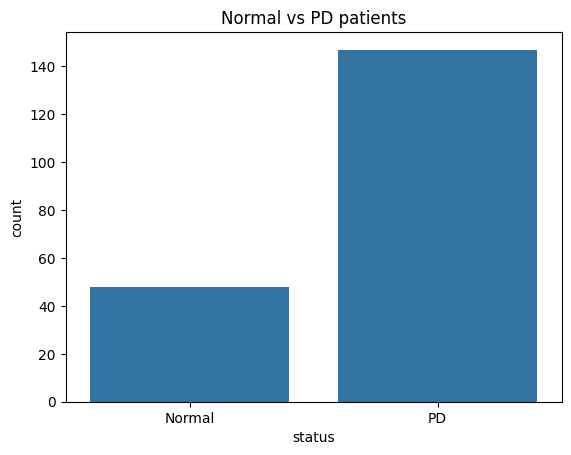

In [6]:
sns.countplot(data=df, x=df['status'])
plt.title("Normal vs PD patients")
plt.xticks(ticks=[0,1], labels=["Normal", "PD"])
plt.show()

Taking the second and third features (MDVP:Flo in x and MDVP:Fo in y) we notice a patient-specific correlation for those values and also that PD (status = 1) have lower values compared to normal. 

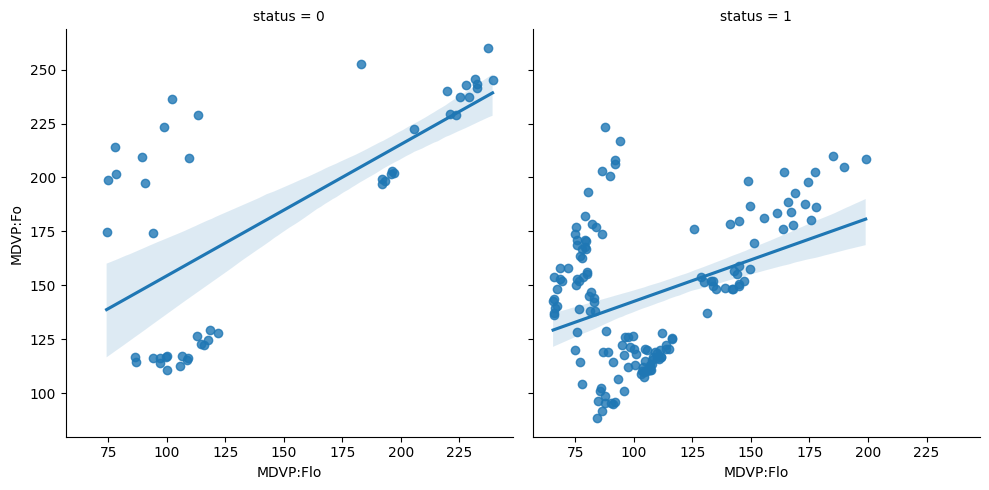

In [7]:
df_normal = df.query('status == 0')
df_PD = df.query('status == 1')

sns.lmplot(data=df, x='MDVP:Flo', y='MDVP:Fo', col='status')

### Data preprocessing and feature selection

Now I'll choose and inspect the best features for my ML model, remove target from dataset and split it into a training and a validation set.   

In [8]:
df.nunique()

name              195
MDVP:Fo           195
MDVP:Fhi          195
MDVP:Flo          195
MDVP:Jitter       173
MDVP:Jitter.1      19
MDVP:RAP          155
MDVP:PPQ          165
Jitter:DDP        180
MDVP:Shimmer      188
MDVP:Shimmer.1    149
Shimmer:APQ3      184
Shimmer:APQ5      189
MDVP:APQ          189
Shimmer:DDA       189
NHR               185
HNR               195
status              2
RPDE              195
DFA               195
spread1           195
spread2           194
D2                195
PPE               195
dtype: int64

We can see that MDVP:Jitter.1 contains the less different values but we do not have to drop any here (the seguent table is **ai-generated**)

| Feature           | Description (focused on Parkinson’s context) |
|-------------------|----------------------------------------------|
| name              | Patient ID, not used for analysis. |
| MDVP:Fo(Hz)       | Average vocal fundamental frequency. Parkinson’s can cause reduced control over pitch, leading to instability. |
| MDVP:Fhi(Hz)      | Maximum vocal frequency. Sudden high values may reflect tremor or loss of smooth control. |
| MDVP:Flo(Hz)      | Minimum vocal frequency. A lower-than-normal range is often linked to vocal fold rigidity. |
| MDVP:Jitter(%)    | Percent variation in cycle-to-cycle frequency. Higher jitter indicates instability, typical in Parkinson’s dysphonia. |
| MDVP:Jitter(Abs)  | Absolute jitter (in seconds). Another measure of pitch micro-instability. |
| MDVP:RAP          | Relative average perturbation (3-cycle). Short-term irregularity of frequency, sensitive to tremor. |
| MDVP:PPQ          | Pitch perturbation quotient (5-cycle). Captures mid-term frequency fluctuations. |
| Jitter:DDP        | Average absolute difference of period lengths (~3×RAP). Highlights frequency irregularity. |
| MDVP:Shimmer      | Cycle-to-cycle variation in amplitude. Parkinson’s often leads to uneven loudness. |
| MDVP:Shimmer(dB)  | Shimmer expressed in dB. Directly interpretable as loudness instability. |
| MDVP:Shimmer.1    | Alternative shimmer calculation. Confirms robustness of amplitude variability. |
| Shimmer:APQ3      | Amplitude perturbation over 3 cycles. Local measure of loudness irregularity. |
| Shimmer:APQ5      | Amplitude perturbation over 5 cycles. Mid-term amplitude variation. |
| MDVP:APQ          | Amplitude perturbation over 11 cycles. Captures longer irregular trends. |
| Shimmer:DDA       | Three-point average absolute difference of amplitude. Sensitive to micro-amplitude changes. |
| NHR               | Noise-to-harmonics ratio. Parkinson’s voices often have more breathiness/noise. |
| HNR               | Harmonics-to-noise ratio. Lower HNR = rougher, noisier voice, common in Parkinson’s. |
| status            | Class label: 1 = Parkinson’s, 0 = healthy control. |
| RPDE              | Recurrence Period Density Entropy. Detects nonlinear irregularity; higher values = more erratic phonation. |
| DFA               | Detrended Fluctuation Analysis. Shows long-range correlations; altered by impaired neuromuscular control. |
| spread1           | First spectral spread measure. Broader spreads = unstable pitch, linked to motor impairment. |
| spread2           | Second spectral spread measure. Complements spread1 for robustness. |
| D2                | Correlation dimension, a fractal measure of complexity. Lower values suggest reduced vocal dynamical richness. |
| PPE               | Pitch Period Entropy. Captures unpredictability of pitch; Parkinson’s often increases pitch randomness. |


In [9]:
num_uniques = df.drop(columns=['status','name'], errors='ignore').nunique().sort_values()
print("Feature counts by uniqueness (ascending):")
print(num_uniques.head(10))
print("\nLeast unique feature appears to be:", num_uniques.index[0], "with", num_uniques.iloc[0], "unique values")

Feature counts by uniqueness (ascending):
MDVP:Jitter.1      19
MDVP:Shimmer.1    149
MDVP:RAP          155
MDVP:PPQ          165
MDVP:Jitter       173
Jitter:DDP        180
Shimmer:APQ3      184
NHR               185
MDVP:Shimmer      188
Shimmer:APQ5      189
dtype: int64

Least unique feature appears to be: MDVP:Jitter.1 with 19 unique values


In [10]:
# The goal here is to use t-student to evaluate the power of feature 
# to use and create the algorithm, later use ROC to inspect the accuracy
# of our model

# ok the first thing is to evaluate if the first 2 features seen have statistc significance
# instead of using t I'll use F classific cause it's more general and the only in scikit

X = df.drop(columns=['status', 'name'])
y = df['status']

selector = SelectKBest(score_func=f_classif, k=2).fit(X, y)

scores = pd.DataFrame({
    "Feature": X.columns,
    "F-score": selector.scores_,
    "p-value": selector.pvalues_
}).sort_values(by="F-score", ascending=False)
print(scores)

           Feature    F-score       p-value
18         spread1  90.424219  7.909651e-18
21             PPE  75.803195  1.392619e-15
19         spread2  50.343165  2.391729e-11
0          MDVP:Fo  33.286577  3.121919e-08
2         MDVP:Flo  32.612875  4.197004e-08
8     MDVP:Shimmer  30.122600  1.264702e-07
12        MDVP:APQ  29.536350  1.643238e-07
15             HNR  29.015927  2.074677e-07
11    Shimmer:APQ5  27.145033  4.823575e-07
9   MDVP:Shimmer.1  27.065484  5.000743e-07
10    Shimmer:APQ3  26.527120  6.386194e-07
13     Shimmer:DDA  26.525626  6.390539e-07
20              D2  25.265912  1.135925e-06
4    MDVP:Jitter.1  25.001729  1.282252e-06
16            RPDE  20.310049  1.139896e-05
6         MDVP:PPQ  17.548533  4.257767e-05
3      MDVP:Jitter  16.192809  8.209989e-05
5         MDVP:RAP  14.775226  1.643393e-04
7       Jitter:DDP  14.772666  1.645466e-04
17             DFA  10.952901  1.115116e-03
14             NHR   7.183270  7.994851e-03
1         MDVP:Fhi   5.478255  2

Ok we found more powerful features that the ones previously guessed, it seems those are the most significant so better explain them again 
1) Spread 1/2: measures the spread of the signal and so the chaos in the measures of voice signal
2) Picth Period Entropy: indicator of unpredictability of the sound

In particular we found that every feature, except for MDVP:Fhi, can already be used alone to identify PD vs normal with a significance of 0.01 (but even with Fhi we'll get a 0.05)

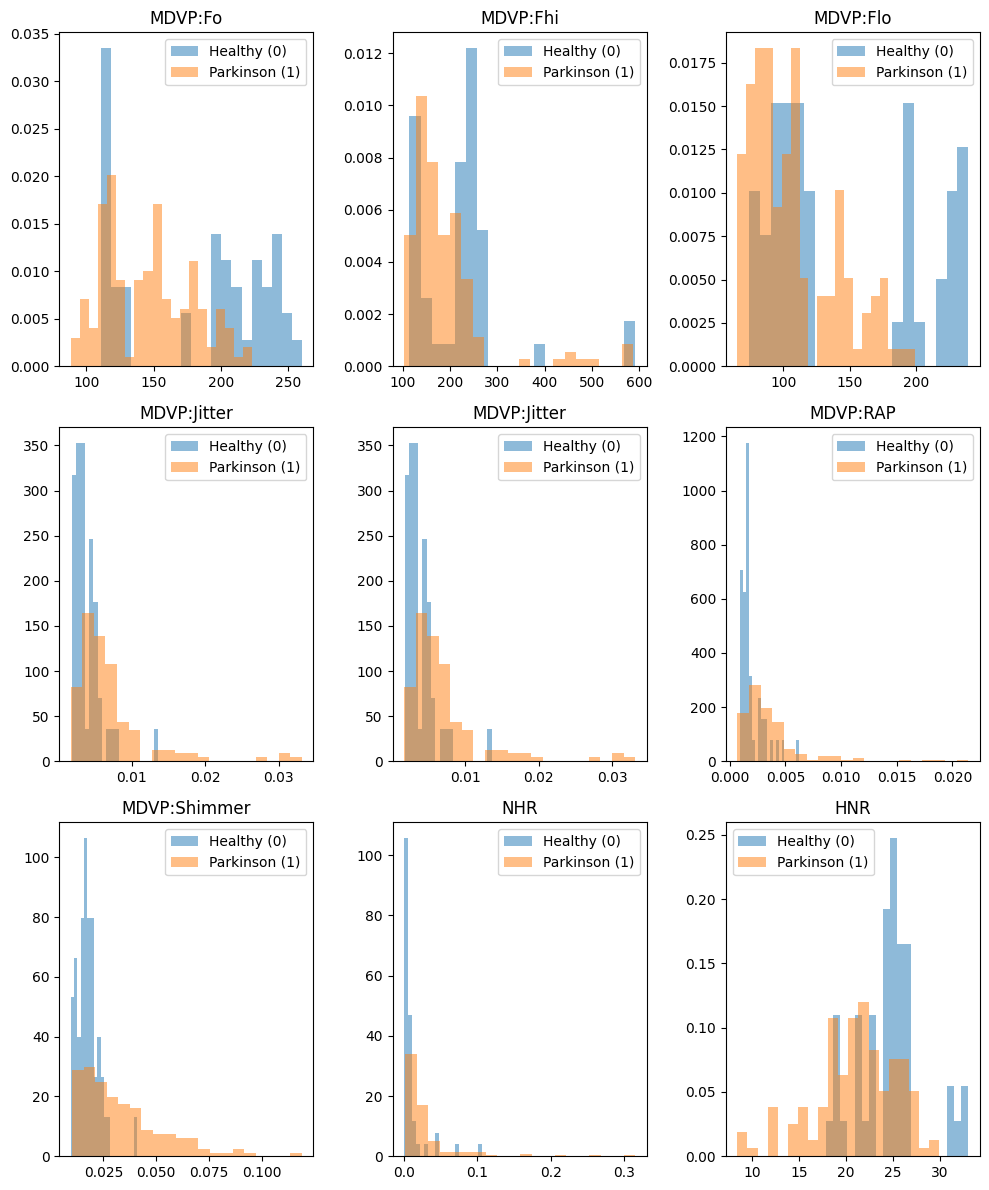

In [11]:
# Plot distributions per class (in this case status) for a set of key features

features_to_plot = [
    'MDVP:Fo','MDVP:Fhi','MDVP:Flo',
    'MDVP:Jitter','MDVP:Jitter','MDVP:RAP',
    'MDVP:Shimmer','MDVP:Shimmer(dB)','NHR','HNR'
]

available = [f for f in features_to_plot if f in df.columns]
cols = 3
rows = 3

# we we'll use a for loop to plot every graph in distinct subsets of all PD and all normal
fig = plt.figure(figsize=(10, 4*rows))
for i, feature in enumerate(available, 1):
    ax = fig.add_subplot(rows, cols, i)
    class0 = df.loc[df['status']==0, feature].dropna()
    class1 = df.loc[df['status']==1, feature].dropna()
    ax.hist(class0, bins=20, alpha=0.5, label='Healthy (0)', density=True)
    ax.hist(class1, bins=20, alpha=0.5, label='Parkinson (1)', density=True)
    ax.set_title(feature)
    ax.legend(loc='best')
plt.tight_layout()
plt.show()

For better evaluating our features, I'm going to perform a chi-square analysis of them. Since the variables are continuous and chi² requires non-negative values, I apply a MinMaxScaler to transform features before computing the scores.

In [12]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import chi2

X_num = df.drop(columns=['status', 'name'], errors='ignore').select_dtypes(include=[np.number]).copy()
y_series = df['status'].astype(int)

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_num.values)
chi2_scores, pvals = chi2(X_scaled, y_series.values)

chi2_df = pd.DataFrame({
    'feature': X_num.columns,
    'chi2': chi2_scores,
    'p_value': pvals
}).sort_values('chi2', ascending=False).reset_index(drop=True)

chi2_df.head(15)

,feature,chi2,p_value
0,MDVP:Flo,6.014075,0.014192
1,spread1,5.832052,0.015737
2,PPE,5.680013,0.017159
3,MDVP:Fo,4.319120,0.037686
4,MDVP:Shimmer,4.215342,0.040060
5,Shimmer:APQ3,4.187889,0.040714
6,Shimmer:DDA,4.185769,0.040765
7,Shimmer:APQ5,3.853073,0.049655
8,MDVP:Shimmer.1,3.774658,0.052035
9,MDVP:APQ,3.352370,0.067108


χ² gives results very similar to the t-test, with the exception of **MDVP:Flo**, which shows the lowest p-value. This happens because the χ² test can *capture differences in how the feature values are distributed between the two classes*, not just differences in the mean. While the t-test focuses only on average differences, χ² is also sensitive to distributional variations (including spread and non-linear patterns).

### Pipeline construction
#### 1.Split data into train and validation sets
Now we select top-k features from the χ² ranking and split the dataset into stratified train/test sets to preserve class balance. In ML it's fundamental to avoid overfitting but also the bias of a specific dataset. 

In [13]:
from sklearn.model_selection import train_test_split

topk = 12
selected_features = chi2_df.head(topk)['feature'].tolist()
X_all = df[selected_features].values
y_all = df['status'].astype(int).values

# creating the division
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, test_size=0.2, stratify=y_all, random_state=42
)

X_train.shape, X_test.shape

((156, 12), (39, 12))

#### 2.Model comparison with Cross-Validation
We will compare several important classifiers (LogReg, SVC, RF, MLP) using 5-fold stratified **Cross Validation** and report mean accuracy, F1, and ROC AUC. With this approach we'll define the best model for our classifier based on the capacity of avoiding overfitting. We create 5 different training set and 1 of test for all, then decide the best model as the one that generalize better and has good results across every fold

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate

models = {
    "LogReg": Pipeline([('scaler', StandardScaler()), ('clf', LogisticRegression(max_iter=500))]),
    "SVC": Pipeline([('scaler', StandardScaler()), ('clf', SVC(probability=True))]),
    "RF": RandomForestClassifier(n_estimators=300, random_state=42),
    "MLP": Pipeline([('scaler', StandardScaler()), ('clf', MLPClassifier(hidden_layer_sizes=(64,32), max_iter=500, random_state=42))])
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = []
for name, model in models.items():
    res = cross_validate(model, X_all, y_all, cv=cv, scoring=['accuracy','f1','roc_auc'],
                         n_jobs=None, return_train_score=False) 
    scores.append({
        'model': name,
        'acc_mean': res['test_accuracy'].mean(),
        'f1_mean': res['test_f1'].mean(),
        'roc_auc_mean': res['test_roc_auc'].mean()
    })

cv_results = pd.DataFrame(scores).sort_values('roc_auc_mean', ascending=False)
cv_results


c:\Users\marco\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\marco\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\marco\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


,model,acc_mean,f1_mean,roc_auc_mean
3,MLP,0.907692,0.938609,0.968352
2,RF,0.902564,0.937741,0.962043
0,LogReg,0.835897,0.895256,0.900868
1,SVC,0.866667,0.918178,0.879413


#### 3.Preprocessing & model pipeline (SVC)

Here we build a pipeline (scaler that normalizes the features + Support Vector Classifier to try to improve the decision boundary) and define the hyperparameters to be explored later via GridSearchCV.

In [15]:
from sklearn.model_selection import GridSearchCV

pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(probability=True))])
param_grid = {
    'svc__C': [0.1, 1, 10, 100],
    'svc__gamma': ['scale', 0.01, 0.1, 1],
    'svc__kernel': ['rbf']
}

pipe, param_grid

(Pipeline(steps=[('scaler', StandardScaler()), ('svc', SVC(probability=True))]),
 {'svc__C': [0.1, 1, 10, 100],
  'svc__gamma': ['scale', 0.01, 0.1, 1],
  'svc__kernel': ['rbf']})

#### 4.Hyperparameter tuning
I'll run GridSearchCV on the SVC pipeline using again the 5-fold stratified CV and ROC AUC as the selection metric, then keep the best estimator for final testing.

In [16]:
grid = GridSearchCV(pipe, param_grid, scoring='roc_auc', cv=cv)
grid.fit(X_train, y_train)

best_model = grid.best_estimator_
print("Best params:", grid.best_params_)
print("Best CV ROC AUC:", grid.best_score_)


Best params: {'svc__C': 100, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}
Best CV ROC AUC: 0.9603972567287784


After the tuning, SVC became pratically as good as MLP (even if it's not a neural network) and so we're gonna choose it for the clarity and relative semplicity (it's ML and so a function that separates data in our two classes, PD or normal, by giving precise weights to features). 

#### 5.Evaluate tuned model performance
Finally we evaluate the tuned model on the test set that we left out by using classification report, confusion matrix and ROC curve (with AUC).

Classification report (test):
              precision    recall  f1-score   support

           0      0.800     0.800     0.800        10
           1      0.931     0.931     0.931        29

    accuracy                          0.897        39
   macro avg      0.866     0.866     0.866        39
weighted avg      0.897     0.897     0.897        39

Confusion matrix:
 [[ 8  2]
 [ 2 27]]


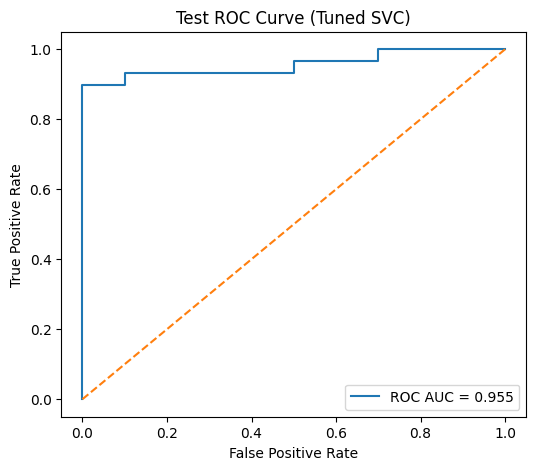

In [17]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

y_proba = best_model.predict_proba(X_test)[:,1]
y_pred = (y_proba >= 0.5).astype(int)

print("Classification report (test):")
print(classification_report(y_test, y_pred, digits=3))

cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n", cm)

fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.3f}')
plt.plot([0,1],[0,1],'--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Test ROC Curve (Tuned SVC)')
plt.legend(loc='lower right')
plt.show()

### Post Hoc Analysis
It's also interesting to watch inside the model to see what importance is giving to every feature and how it's using the ones that were more significant. To do that we use permutation importance on the test set to estimate which selected feature contribute most to the tuned model’s predictions.

In [18]:
from sklearn.inspection import permutation_importance

r = permutation_importance(best_model, X_test, y_test, n_repeats=30, random_state=42)
importances = r.importances_mean
indices = np.argsort(importances)[::-1]

print("Top features by permutation importance:")
for i in indices[:10]:
    print(f"{selected_features[i]}: {importances[i]:.4f}")

Top features by permutation importance:
spread1: 0.1444
MDVP:Fo: 0.1239
MDVP:Flo: 0.0564
Shimmer:APQ5: 0.0538
spread2: 0.0487
MDVP:APQ: 0.0376
PPE: 0.0316
Shimmer:DDA: 0.0308
Shimmer:APQ3: 0.0308
MDVP:Shimmer.1: 0.0274


### Limitations
Why we cannot use **this** model to diagnose Parkinson's disease?

1) *The dataset is limited*: we have less than 140 patients with Parkinson from which we extract "patholocical patterns" to use to analyze other people and also those represents only one specific population. The interpersonal variability affects measurements so much that performance may drop significantly on larger and more heterogeneous groups

2) *The model is limited*: The high AUC was obtained only in a synthetic environment (cross-validation on a small dataset) and it has not been externally validated on independent cohorts or in a real clinical setting

3) *The methods are limited*: diagnosing a chronic neurodegenerative disease requires a multidimensional approach, combining clinical history, neurological examination, imaging and biomarkers. Relying exclusively on voice parameters oversimplifies the diagnostic process